# 라이브러리

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import os
from openpyxl import load_workbook
from openpyxl.styles import Font

from time import sleep
from dotenv import load_dotenv

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options 
from selenium.webdriver.common.keys import Keys # <--- 대문자 Keys
from selenium.webdriver.common.by import By
import undetected_chromedriver as uc
from selenium.webdriver.support.ui import WebDriverWait
from fake_useragent import UserAgent
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException

# 크롬 드라이버 자동 업데이트
from webdriver_manager.chrome import ChromeDriverManager

# 변수 설정 및 하이퍼링크 주소 복원한 데이터프레임 생성

In [31]:
# 보안상의 이유로 환경변수로 ID와 PASSWORD 핸들링
# .env 파일 경로
dotenv_path = '.env'
# .env 파일 로드
load_dotenv(dotenv_path)
id = os.getenv('GPT_ID_EMAIL') 
pwd = os.getenv('GPT_PASSWORD')

file_path = './data/_v3_.xlsx'
sheet_name = ''

# 액셀파일 필요한 행 정보
row_dict = {
}

check_point_list = [
]

# 엑셀파일에 시트가 여러개이나 사용할 시트는 ''
raw_df = pd.read_excel(file_path, sheet_name=None) # list(row_df.keys()) 시트 구별
df = raw_df[sheet_name]
row_lst = list(row_dict.keys())

# 하이퍼링크를 유지하기 위한 액셀파일 읽어오기
wb = load_workbook(file_path, data_only=True)
ws = wb[sheet_name]
url_row = ws[3] # 하이퍼링크가 있는 행 액셀 기준 3행

for idx, cell in enumerate(url_row):  
    if cell.hyperlink:
        df.loc[1, idx-1] = cell.hyperlink.target
    else:
        df.loc[1, idx-1] = cell.value

# 켑챠 인증 우회 셀레니움 드라이브 실행 후 로그인

In [107]:
# 캡챠 인증 등 위회 가능
op = webdriver.ChromeOptions()
op.add_argument(f"user-agent={UserAgent.random}")
op.add_argument("user-data-dir=./")
op.add_experimental_option("detach", True)
op.add_experimental_option("excludeSwitches", ["enable-logging"])

driver = uc.Chrome(chrome_options=op)
driver.get('https://chat.openai.com/')
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))

# 로그인
login_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//div[contains(text(), '로그인')]")))
driver.execute_script("arguments[0].click();", login_button)

email_input = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "email-input")))
email_input.send_keys(id)

continue_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, "continue-btn")))
continue_button.click()

password_input = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "password")))
password_input.send_keys(pwd)

final_continue_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[data-action-button-primary='true']")))
final_continue_button.click()

# 함수

In [108]:
# GPT 버전 얻는 함수
def get_gpt_version():
    try:
        # ChatGPT의 모델(버전)명이 쓰여있는 요소 찾기
        # version_element = driver.find_element(By.CSS_SELECTOR, '[id*="radix-"] > div > span')
        version_element = driver.find_element(By.XPATH, '//*[contains(@id, "radix-")]/div/span')
        version_text = version_element.text
        return version_text
    except Exception as e:
        return None

# GPT 버전 체크(코드 진행을 위함)    
def check_gpt_version():
    while True:
        try:
            gpt_limit_alarm = driver.find_element(By.XPATH, "//div[contains(@class, 'flex') and contains(@class, 'w-full') and contains(@class, 'items-start') and contains(., 'You’ve reached your GPT-4o limit.')]")
            if gpt_limit_alarm:
                print("GPT4 사용량이 한도에 달해 GPT 3.5버전으로 변경되었습니다.")
                return "3.5"
        except NoSuchElementException:
            pass
        try:
            gpt_version = get_gpt_version()
            if gpt_version in ["3.5", "4", "4o"]:
                return gpt_version
        except Exception as e:
            print(f"GPT 버전을 확인하는 중 오류 발생: {e}")
                
# 답변 생성중인걸 기다리기 위한 객체
wait = WebDriverWait(driver, 300)
# GPT가 답변생성을 완료하면 진행할수있게 하는 함수
def wait_gpt_message(wait):
    # GPT가 답변 생성시간이 일정하지않고 생성중 버튼이 바뀌는 것에서 착안
    # 답변 생성 중일 때 버튼의 클래스가 icon-lg임을 확인 ㅁ(중단)버튼
    # 답변 생성이 완료되면 버튼의 클래스가 다시 icon-2xl로 바뀜을 확인 전송 버튼
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "svg.icon-lg"))) # 중단 버튼이 확인되면 다음 코드 실행
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "svg.icon-2xl"))) # 전송 버튼이 확인되면 다음 코드 실행
    sleep(1)

# # 하이퍼링크 만들기
# def make_hyper(url):
#     return '=HYPERLINK("%s", "%s")' % (url.format(url), url)

# 로그 파일에 로그 작성 함수
def write_log(message):
    # 현재 시간을 로그에 포함하기 위해 현재 시간을 가져옵니다.
    current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    # 로그 메시지를 형식에 맞게 작성합니다.
    log_message = f"{current_time} - {message}\n"
    
    # 로그 파일에 메시지를 추가 모드('a')로 엽니다.
    with open('./data/log.txt', 'a', encoding='utf-8') as file:
        file.write(log_message)

# 생성된 데이터에 특정 텍스트가 있는지 확인
def check_data_in_text(text, check_point):
    for point in check_point:
        # 한글 단어 경계를 포함한 정규 표현식
        if not re.search(rf'(?<![가-힣]){re.escape(point)}(?![가-힣])', text):
            log_message = f'{point} 항목이 생성된 데이터에 없습니다.'
            write_log(log_message)
            print(log_message)

### 생성할 데이터가 맞는지 확인

In [4]:
colnum = 449 # 인덱스 번호 아님 컬럼 이름임 (2~11, 22~160)
print(df.loc[row_lst, colnum] )

# 생성된 데이터 용량 확인
size_check_lst = []
total_length = 0

for row in row_lst:
    try:
        size_check_lst.append(df.loc[row,colnum].replace('\n', ' '))
    except AttributeError:
        print(f"{colnum}번 {row}행 {row_dict[row]}에 값이 없습니다.")
    except Exception as e:
        print(f"예기치 못한 오류 {e}")

for text_data in size_check_lst:
    total_length += len(text_data.encode('utf-8'))

txt_size = round(total_length/1024, 2)
print(f'용량 : {txt_size}KB')

Name: 449, dtype: object
용량 : 46.74KB


# 자동화 코드
* GPT버전이 3.5면 중지
* 데이터 프레임을 엑셀로 저장 후 하이퍼링크로 변경해 저장
* log파일 기록
* 기타 작업들 하며 데이터 생성

In [16]:
flag = False
start_time = datetime.datetime.now() # 작업 시작 시각
for i in range(colnum, 451):
    try:
        # 사용중인 GPT버전 확인 3.5면 중지 그 이외 버전이면(4, 4o) 진행
        version = check_gpt_version()
        if version == "3.5":
            write_log("GPT 버전이 3.5로 변경되었습니다.")
            print(f"GPT 버전이 3.5로 {i}번 작업을 중단합니다.")
            break
        
        # 작업정보 출력
        company_name = df[i][0]
        item_name = df[i][51]
        summary = df[i][52]
        write_log(f'{i}번째 데이터 생성 시작 <{company_name}, {item_name}>')
        print(f'{i}번째 작업 시작. 회사명 : {company_name}')
        print(f"창업 아이템 : {item_name}")
        prompt = f"창업 아이템 명 : {item_name}\n제품/서비스 요약 : {summary}\n이고 1번 항목 먼저 작성해줘"

        # gpt 시작 페이지에서 시작
        message_box = driver.find_element(By.ID, "prompt-textarea") # 채팅 입력창 찾기
        # 메세지 자동 전송을 막기위해 전송버튼 이벤트 비활성화
        driver.execute_script("arguments[0].removeEventListener('input', arguments[0].oninput);", message_box)
        driver.execute_script("arguments[0].value = arguments[1];", message_box, prompt) # send_keys로 장문 입력시 오류 방지
        sleep(1)
        message_box.send_keys(Keys.ENTER) # 전송버튼 이벤트 활성화
        message_box.send_keys(Keys.ENTER) # 활성화된 버튼으로 메세지 전송
        wait_gpt_message(wait)
        
        version = check_gpt_version()
        if version == "3.5":
            write_log("GPT 버전이 3.5로 변경되었습니다.")
            print(f"GPT 버전이 3.5로 {i}-1번 작업을 중단합니다.")
            break

        # 2번~10번 정보 생성
        for num in range(2,11):
            # 사용중인 GPT버전 확인 3.5면 중지 그 이외 버전이면(4, 4o) 진행
            version = check_gpt_version()
            if version == "3.5":
                write_log("GPT 버전이 3.5로 변경되었습니다.")
                print(f"GPT 버전이 3.5로 {i}-{num}작업을 중단합니다.")
                flag = True
                break

            message_box.send_keys(num)
            message_box.send_keys(Keys.ENTER)
            wait_gpt_message(wait)
        
        # 챗봇 메시지 요소들 찾기
        # user_messages = driver.find_elements(By.CSS_SELECTOR, "div[data-message-author-role='user']") # 사용자 메시지
        bot_messages = driver.find_elements(By.CSS_SELECTOR, "div[data-message-author-role='assistant']")

        # 메시지를 저장할 리스트 초기화
        bot_message_texts = []

        # 챗봇 메시지 텍스트 추출 및 리스트에 추가
        for message in bot_messages: 
            bot_message_texts.append(message.text.replace('\n', ' '))
        
        # 생성된 데이터 용량 확인
        total_length = 0
        for message_text in bot_message_texts:
            total_length += len(message_text.encode('utf-8'))
        txt_size = round(total_length/1024, 2)
        write_log(f'생성된 데이터 용량 {txt_size}KB')
        print(f'용량 : {txt_size}KB')

        # 엑셀 파일에 요소 넣기
        for row, data in zip(row_lst[4:], bot_message_texts): 
            df.loc[row,i] = data

        # GPT의 한개의 답변이 나뉘어서 저장된 경우 확인 필요
        # 나뉜경우 답변이 밀려서 텍스트가 추출되도 df에 데이터가 들어가지 않는 경우 방지
        if len(bot_message_texts) > 10:
            write_log(f'데이터 {i}의 추출한 메세지 갯수가 10을 초과하였습니다.')
            print(f'{i}번 확인 필요')
            for k, over in enumerate(bot_message_texts[11:]):
                df.loc[102+k,i] = over
        elif len(bot_message_texts) == 10:
            # missing_point = []
            for txt, ckp in zip(bot_message_texts[5:], check_point_list):
                # check_data_in_text(txt, ckp)
                check_data_in_text(txt, ckp)
        #         for mpoing in missing:
        #             missing_point.append(mpoing)  
        # if len(missing_point) > 0:      
        #     write_log(f'생성한 데이터에 {missing} 항목이 누락되었습니다.')
        
        # 작업한 채팅방 url추출해서 확인
        current_url = driver.current_url
        write_log(f'데이터 생성 URL : {current_url}')
        print("URL :", current_url)
        df.loc[1, i] = current_url

        print(f'{i}번째 작업 생성 완료.')

        if flag:
            break

        print()

        # gpt 시작 페이지로
        driver.get('https://chatgpt.com/')
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        sleep(2)

    except Exception as e:
        print(e)
        print(f"{i}번째 데이터 생성중 오류로 중단합니다.")
        break

# 작업한 데이터프레임 저장
raw_df[sheet_name] = df
with pd.ExcelWriter(file_path) as writer:
    for sheet, data in raw_df.items():
        data.to_excel(writer, sheet_name=sheet, index=False)


# 하이퍼링크 스타일 적용
wb = load_workbook(file_path, data_only=True)
ws = wb[sheet_name]
hyper_row = ws[3]
for cell in hyper_row[2:]:
    if cell.value:  # 셀 값이 존재하는 경우에만 처리
        cell.hyperlink = cell.value  # 하이퍼링크 설정
        cell.value = "링크"  # 셀의 표시 텍스트 변경
        cell.font = Font(color='0000FF', underline='single')  # 하이퍼링크 스타일 적용
wb.save(file_path)

end_time = datetime.datetime.now() # 작업 종료 시각
run_time = end_time - start_time
write_log(f'작업 시간 : {run_time} 소요')

# 작업 완료후 브라우저 종료
# driver.close()

449번째 작업 시작. 회사명 : 
창업 아이템 : 
용량 : 45.77KB
URL : 
449번째 작업 생성 완료.

450번째 작업 시작. 회사명 : 
창업 아이템 : 
용량 : 42.49KB
URL : 
450번째 작업 생성 완료.



In [30]:
col = 409
write_log(f'{col}번째 데이터 단일 추출 후 액셀에 저장')
bot_messages = driver.find_elements(By.CSS_SELECTOR, "div[data-message-author-role='assistant']")
 
# 메시지를 저장할 리스트 초기화
bot_message_texts = []
# 챗봇 메시지 텍스트 추출 및 리스트에 추가
for message in bot_messages:
    bot_message_texts.append(message.text.replace('\n', ' '))
 
# 생성된 데이터 용량 확인
total_length = 0
for message_text in bot_message_texts:
    total_length += len(message_text.encode('utf-8'))
txt_size = round(total_length/1024, 2)
write_log(f'생성된 데이터 용량 {txt_size}KB')
print(f'용량 : {txt_size}KB')
 
bot_message_texts
 
# 엑셀 파일에 요소 넣기
for row, data in zip(row_lst[4:], bot_message_texts):
    df.loc[row,col] = data.replace('\n', ' ')
# GPT의 한개의 답변이 나뉘어서 저장된 경우 확인 필요
# 나뉜경우 답변이 밀려서 텍스트가 추출되도 df에 데이터가 들어가지 않는 경우 방지
if len(bot_message_texts) > 10:
    print(f'{col}번 확인 필요')
    for k, over in enumerate(bot_message_texts[11:]):
        df.loc[102+k,col] = over.replace('\n', ' ')
elif len(bot_message_texts) == 10:
    missing_point = []
    for txt, ckp in zip(bot_message_texts[5:], check_point_list):
        check_data_in_text(txt, ckp)
 
current_url = driver.current_url
write_log(f'데이터 생성 URL : {current_url}')
print("URL :", current_url)
df.loc[1, col] = current_url
 
# 작업한 데이터프레임 저장
raw_df[sheet_name] = df
with pd.ExcelWriter(file_path) as writer:
    for sheet, data in raw_df.items():
        data.to_excel(writer, sheet_name=sheet, index=False)
 
# 하이퍼링크 스타일 적용
wb = load_workbook(file_path, data_only=True)
ws = wb[sheet_name]
hyper_row = ws[3]
for cell in hyper_row[2:]:
    if cell.value:  # 셀 값이 존재하는 경우에만 처리
        cell.hyperlink = cell.value  # 하이퍼링크 설정
        cell.value = "링크"  # 셀의 표시 텍스트 변경
        cell.font = Font(color='0000FF', underline='single')  # 하이퍼링크 스타일 적용
wb.save(file_path)

용량 : 43.1KB
URL : 


### 데이터 검수

In [127]:
# 생성된 데이터 용량이 40kb미만인 번호가 들어갈 리스트
fall_short_of_data_lst = []
data_num = [] 
data_size = []
for i in range (2,451):
    if (12 <= i <= 21) or (161 <= i <= 299):
        continue
    size_check_lst = []
    total_length = 0

    for row in row_lst[3:]:
        try:
            size_check_lst.append(df.loc[row,i].replace('\n', ' '))
        except AttributeError:
            print(f"{i}번 {row_dict[row]}에 값이 없습니다.")
        except Exception as e:
            print(f"예기치 못한 오류 {e}")

    for text_data in size_check_lst:
        total_length += len(text_data.encode('utf-8'))

    txt_size = round(total_length/1024, 2)

    data_num.append(i)
    data_size.append(txt_size)

    if txt_size <= 40:
        fall_short_of_data_lst.append(i)
    print(f"{i}번 용량 : {txt_size}KB")
    
fall_short_of_data_lst

[]

In [122]:
size_chart = {'번호' : data_num,
            '용량(KB)' : data_size}
gen_data_df=pd.DataFrame(size_chart)

In [123]:
gen_data_df['용량(KB)'].describe()

count    300.000000
mean      49.024533
std        3.732564
min       40.440000
25%       46.372500
50%       48.935000
75%       51.522500
max       63.080000
Name: 용량(KB), dtype: float64

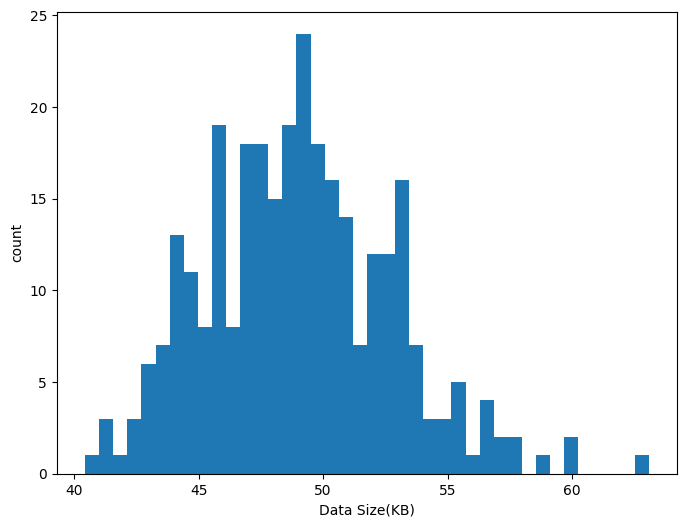

In [124]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정 (나눔글꼴을 사용하도록 설정)
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'  # 나눔고딕 볼드 폰트 경로
# font_name = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font_name)
plt.figure(figsize=(8, 6))
# plt.plot(data_num, data_size, marker='o')
plt.hist(data_size, bins=40)
plt.xlabel('Data Size(KB)')
plt.ylabel('count')
# plt.grid(True)
plt.show()

In [15]:
# 생성된 데이터에 특정 텍스트가 있는지 확인
def check_data_in_text(text, check_point):
    for point in check_point:
        # 한글 단어 경계를 포함한 정규 표현식
        if not re.search(rf'(?<![가-힣]){re.escape(point)}(?![가-힣])', text):
            log_message = f'{point} 항목이 생성된 데이터에 없습니다.'
            # write_log(log_message)
            print(log_message)

In [128]:
row_lst[-5:]

[64, 74, 84, 93, 101]

In [129]:
re_gen_lst = []
for i in range(2, 451):
    if (12 <= i <= 21) or (161 <= i <= 299):
        continue
    gen_data = []
    for row in row_lst[-5:]:
        try:
            excel_txt = df.loc[row,i].replace('\n', ' ')
            if row == 64:
                excel_txt = excel_txt.replace('핵심파트너', '핵심 파트너')
            elif row == 84:
                excel_txt = excel_txt.replace('SO전략', 'SO 전략')
                excel_txt = excel_txt.replace('WT전략', 'WT 전략')
                excel_txt = excel_txt.replace('ST전략', 'ST 전략')
                excel_txt = excel_txt.replace('WO전략', 'WO 전략')
            # gen_data.append(df.loc[row,i].replace('\n', ' '))
            gen_data.append(excel_txt)
        except AttributeError:
            print(f"{i}번 {row_dict[row]}에 값이 없습니다.")
            re_gen_lst.append(i)
        except Exception as e:
            print(f"예기치 못한 오류 {e}")
    
    for k, (txt, ckp) in enumerate(zip(gen_data, check_point_list)):
        for point in ckp:
            if not re.search(rf'(?<![가-힣]){re.escape(point)}(?![가-힣])', txt):
                print(f'{i}번 {k+6}번 {point} 항목이 생성된 데이터에 없습니다.')
                re_gen_lst.append(i)
            
            # check_data_in_text(txt, ckp)


In [130]:
from collections import OrderedDict
list(OrderedDict.fromkeys(re_gen_lst))

[]

In [119]:
regen = [356]

In [120]:
flag = False
start_time = datetime.datetime.now() # 작업 시작 시각
for i in regen:
    try:
        # 사용중인 GPT버전 확인 3.5면 중지 그 이외 버전이면(4, 4o) 진행
        version = check_gpt_version()
        if version == "3.5":
            write_log("GPT 버전이 3.5로 변경되었습니다.")
            print(f"GPT 버전이 3.5로 {i}번 작업을 중단합니다.")
            break
        
        # 작업정보 출력
        company_name = df[i][0]
        item_name = df[i][51]
        summary = df[i][52]
        write_log(f'{i}번째 데이터 생성 시작 <{company_name}, {item_name}>')
        print(f'{i}번째 작업 시작. 회사명 : {company_name}')
        print(f"창업 아이템 : {item_name}")
        prompt = f"창업 아이템 명 : {item_name}\n제품/서비스 요약 : {summary}\n이고 1번 항목 먼저 작성해줘"

        # gpt 시작 페이지에서 시작
        message_box = driver.find_element(By.ID, "prompt-textarea") # 채팅 입력창 찾기
        # 메세지 자동 전송을 막기위해 전송버튼 이벤트 비활성화
        driver.execute_script("arguments[0].removeEventListener('input', arguments[0].oninput);", message_box)
        driver.execute_script("arguments[0].value = arguments[1];", message_box, prompt) # send_keys로 장문 입력시 오류 방지
        sleep(1)
        message_box.send_keys(Keys.ENTER) # 전송버튼 이벤트 활성화
        message_box.send_keys(Keys.ENTER) # 활성화된 버튼으로 메세지 전송
        wait_gpt_message(wait)
        
        version = check_gpt_version()
        if version == "3.5":
            write_log("GPT 버전이 3.5로 변경되었습니다.")
            print(f"GPT 버전이 3.5로 {i}-1번 작업을 중단합니다.")
            break

        # 2번~10번 정보 생성
        for num in range(2,11):
            # 사용중인 GPT버전 확인 3.5면 중지 그 이외 버전이면(4, 4o) 진행
            version = check_gpt_version()
            if version == "3.5":
                write_log("GPT 버전이 3.5로 변경되었습니다.")
                print(f"GPT 버전이 3.5로 {i}-{num}작업을 중단합니다.")
                flag = True
                break

            message_box.send_keys(num)
            message_box.send_keys(Keys.ENTER)
            wait_gpt_message(wait)
        
        # 챗봇 메시지 요소들 찾기
        # user_messages = driver.find_elements(By.CSS_SELECTOR, "div[data-message-author-role='user']") # 사용자 메시지
        bot_messages = driver.find_elements(By.CSS_SELECTOR, "div[data-message-author-role='assistant']")

        # 메시지를 저장할 리스트 초기화
        bot_message_texts = []

        # 챗봇 메시지 텍스트 추출 및 리스트에 추가
        for message in bot_messages: 
            bot_message_texts.append(message.text.replace('\n', ' '))
        
        # 생성된 데이터 용량 확인
        total_length = 0
        for message_text in bot_message_texts:
            total_length += len(message_text.encode('utf-8'))
        txt_size = round(total_length/1024, 2)
        write_log(f'생성된 데이터 용량 {txt_size}KB')
        print(f'용량 : {txt_size}KB')

        # 엑셀 파일에 요소 넣기
        for row, data in zip(row_lst[4:], bot_message_texts): 
            df.loc[row,i] = data

        # GPT의 한개의 답변이 나뉘어서 저장된 경우 확인 필요
        # 나뉜경우 답변이 밀려서 텍스트가 추출되도 df에 데이터가 들어가지 않는 경우 방지
        if len(bot_message_texts) > 10:
            write_log(f'데이터 {i}의 추출한 메세지 갯수가 10을 초과하였습니다.')
            print(f'{i}번 확인 필요')
            for k, over in enumerate(bot_message_texts[11:]):
                df.loc[102+k,i] = over
        elif len(bot_message_texts) == 10:
            # missing_point = []
            for txt, ckp in zip(bot_message_texts[5:], check_point_list):
                # check_data_in_text(txt, ckp)
                check_data_in_text(txt, ckp)
        #         for mpoing in missing:
        #             missing_point.append(mpoing)  
        # if len(missing_point) > 0:      
        #     write_log(f'생성한 데이터에 {missing} 항목이 누락되었습니다.')
        
        # 작업한 채팅방 url추출해서 확인
        current_url = driver.current_url
        write_log(f'데이터 생성 URL : {current_url}')
        print("URL :", current_url)
        df.loc[1, i] = current_url

        print(f'{i}번째 작업 생성 완료.')

        if flag:
            break

        print()

        # gpt 시작 페이지로
        driver.get('https://chatgpt.com/')
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        sleep(2)

    except Exception as e:
        print(e)
        print(f"{i}번째 데이터 생성중 오류로 중단합니다.")
        break

# 작업한 데이터프레임 저장
raw_df[sheet_name] = df
with pd.ExcelWriter(file_path) as writer:
    for sheet, data in raw_df.items():
        data.to_excel(writer, sheet_name=sheet, index=False)


# 하이퍼링크 스타일 적용
wb = load_workbook(file_path, data_only=True)
ws = wb[sheet_name]
hyper_row = ws[3]
for cell in hyper_row[2:]:
    if cell.value:  # 셀 값이 존재하는 경우에만 처리
        cell.hyperlink = cell.value  # 하이퍼링크 설정
        cell.value = "링크"  # 셀의 표시 텍스트 변경
        cell.font = Font(color='0000FF', underline='single')  # 하이퍼링크 스타일 적용
wb.save(file_path)

end_time = datetime.datetime.now() # 작업 종료 시각
run_time = end_time - start_time
write_log(f'작업 시간 : {run_time} 소요')

# 작업 완료후 브라우저 종료
# driver.close()

356번째 작업 시작. 회사명 : 
창업 아이템 : 
용량 : 47.54KB
URL : 
356번째 작업 생성 완료.



In [131]:
# 작업한 데이터프레임 저장
raw_df[sheet_name] = df
with pd.ExcelWriter(file_path) as writer:
    for sheet, data in raw_df.items():
        data.to_excel(writer, sheet_name=sheet, index=False)


# 하이퍼링크 스타일 적용
wb = load_workbook(file_path, data_only=True)
ws = wb[sheet_name]
hyper_row = ws[3]
for cell in hyper_row[2:]:
    if cell.value:  # 셀 값이 존재하는 경우에만 처리
        cell.hyperlink = cell.value  # 하이퍼링크 설정
        cell.value = "링크"  # 셀의 표시 텍스트 변경
        cell.font = Font(color='0000FF', underline='single')  # 하이퍼링크 스타일 적용
wb.save(file_path)